# Import Package

In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import (
      mean_absolute_error,
      mean_squared_error,
      r2_score
)

# Import Dataset

In [2]:
df = pd.read_csv("../data/processed/datamart_final.csv")

df.sample(5)

,CODE_UNIT,DATE,AMOUNT,HM_CALC,CONSUMPTION,HM_HRS,PRODUCTION_OB,CONSUMPTION_CALC,CONSUMPTION_HRS
1381,EX44,2022-10-14,858.0,9.0,215.642857,NaN,5375.0,95.333333,NaN
1025,EX43,2022-10-23,2003.0,21.0,82.627273,18.0,8101.0,95.380952,111.277778
129,EX41,2022-05-10,2204.0,21.0,106.972727,NaN,NaN,104.952381,NaN
52,EX41,2022-02-22,1387.0,16.0,108.783333,10.0,4620.0,86.687500,138.700000
111,EX41,2022-04-22,0.0,0.0,NaN,17.0,8177.0,NaN,0.000000


In [3]:
df.drop('CONSUMPTION', axis = 1, inplace=True)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   CODE_UNIT         1460 non-null   object 
 1   DATE              1460 non-null   object 
 2   AMOUNT            1460 non-null   float64
 3   HM_CALC           1460 non-null   float64
 4   HM_HRS            624 non-null    float64
 5   PRODUCTION_OB     1354 non-null   float64
 6   CONSUMPTION_CALC  1396 non-null   float64
 7   CONSUMPTION_HRS   623 non-null    float64
dtypes: float64(6), object(2)
memory usage: 91.4+ KB


In [5]:
df.sample(10)

,CODE_UNIT,DATE,AMOUNT,HM_CALC,HM_HRS,PRODUCTION_OB,CONSUMPTION_CALC,CONSUMPTION_HRS
592,EX42,2022-08-16,2575.0,20.0,NaN,4859.0,128.750000,NaN
10,EX41,2022-01-11,1645.0,7.0,21.0,11520.0,235.000000,78.333333
1420,EX44,2022-11-22,2199.0,20.0,NaN,10664.0,109.950000,NaN
1102,EX44,2022-01-08,1550.0,21.0,NaN,7869.0,73.809524,NaN
1130,EX44,2022-02-05,1005.0,18.0,NaN,5246.0,55.833333,NaN
515,EX42,2022-05-31,954.0,6.0,NaN,10492.0,159.000000,NaN
142,EX41,2022-05-23,1714.0,17.0,NaN,NaN,100.823529,NaN
714,EX42,2022-12-16,1021.0,189.0,NaN,7138.0,5.402116,NaN
83,EX41,2022-03-25,2028.0,20.0,20.0,10120.0,101.400000,101.400000
1005,EX43,2022-10-03,1633.0,17.0,0.0,0.0,96.058824,inf


**Data Dictionary**

- CODE_UNIT : Code Unit Excavator
- DATE : Tanggal pencatatan
- Amount : Jumlah Bahan Bakar digunakan
- HM_Calc : Perhitungan HM berdasarkan versi kelompok 6
- Consumption : Konsumsi bahan 
- HM_HRS : HM berdasarkan data produksi HRS
- Production_OB : Jumlah produksi overburder berdasarkan data HRS dan perhitungan ritase (ritase x 43)
- Consumption_Calc : Konsumsi bahan bakar per jam (Amount/HM_Calc)
- Consumption_HRS : Konsumsi bahan bakar per jam berdasarkan HM HRS (Amount/HM_HRS)

# Exploratory Data Analysis

## Check null value

In [6]:
df.isna().sum()

CODE_UNIT             0
DATE                  0
AMOUNT                0
HM_CALC               0
HM_HRS              836
PRODUCTION_OB       106
CONSUMPTION_CALC     64
CONSUMPTION_HRS     837
dtype: int64

**Note**

- Null pada HM_HRS disebabkan data yang tersedia hanya untuk 2 excavator (EX41 dan EX43)
- Data PRODUCTION_OB didasarkan pada data production yang diberikan dari HRS (EX41 dan 43) dan juga hasil perkalian ritase x43 (berdasarkan data ritase EX42 dan EX44)
- Production_OB tidak ditemukan berarti tidak ada padanan data produksi berdasar data HRS pada tanggal tersebut
- Ketika data amount tersedia namun data production tidak tersedia maka akan dilakukan drop, sementara null pada HRS tidak akan di drop

In [7]:
df = df[df['PRODUCTION_OB'].notna()]

In [8]:
df

,CODE_UNIT,DATE,AMOUNT,HM_CALC,HM_HRS,PRODUCTION_OB,CONSUMPTION_CALC,CONSUMPTION_HRS
1,EX41,2022-01-02,2362.0,11.0,20.0,10350.0,214.727273,118.100000
2,EX41,2022-01-03,1961.0,20.0,22.0,11565.0,98.050000,89.136364
3,EX41,2022-01-04,1950.0,23.0,14.0,6750.0,84.782609,139.285714
4,EX41,2022-01-05,1744.0,17.0,21.0,11475.0,102.588235,83.047619
5,EX41,2022-01-06,1060.0,23.0,13.0,6255.0,46.086957,81.538462
...,...,...,...,...,...,...,...,...
1455,EX44,2022-12-27,1137.0,17.0,NaN,2021.0,66.882353,NaN
1456,EX44,2022-12-28,2061.0,22.0,NaN,9073.0,93.681818,NaN
1457,EX44,2022-12-29,1524.0,15.0,NaN,7052.0,101.600000,NaN
1458,EX44,2022-12-30,2091.0,21.0,NaN,10965.0,99.571429,NaN


## Outlier Checking

In [9]:
df.describe()

,AMOUNT,HM_CALC,HM_HRS,PRODUCTION_OB,CONSUMPTION_CALC,CONSUMPTION_HRS
count,1354.000000,1354.000000,624.000000,1354.000000,1298.000000,623.000000
mean,1646.991137,16.401773,16.439103,7642.615066,inf,inf
std,617.893294,160.399758,5.575138,2966.847316,NaN,NaN
min,0.000000,-3970.000000,0.000000,0.000000,-70.636364,0.000000
25%,1322.000000,14.000000,14.000000,6036.750000,90.372727,73.785965
50%,1800.000000,18.000000,18.000000,8228.000000,100.090074,98.285714
75%,2073.750000,21.000000,21.000000,9847.000000,112.679825,130.289683
max,2862.000000,4011.000000,23.000000,13588.000000,inf,inf


## Remove infnity value

In [10]:
df = df[df['CONSUMPTION_CALC']!=np.inf] #remove infinity value from consumption calc
df = df[df['CONSUMPTION_HRS']!=np.inf] #remove infinity value from consumptio hrs

In [11]:
df.describe()

,AMOUNT,HM_CALC,HM_HRS,PRODUCTION_OB,CONSUMPTION_CALC,CONSUMPTION_HRS
count,1300.000000,1300.000000,586.000000,1300.000000,1244.000000,585.000000
mean,1664.947692,16.769231,17.105802,7798.039462,107.668231,111.421474
std,613.591463,163.679729,4.560691,2789.665367,83.033330,92.479663
min,0.000000,-3970.000000,0.000000,0.000000,-70.636364,0.000000
25%,1352.750000,14.000000,14.250000,6166.250000,90.266667,74.105263
50%,1817.500000,18.000000,18.000000,8299.000000,99.699248,97.190476
75%,2083.500000,21.000000,21.000000,9890.000000,111.607895,124.157895
max,2862.000000,4011.000000,23.000000,13588.000000,2029.000000,1145.500000


## Remove Outlier from HM Calculation

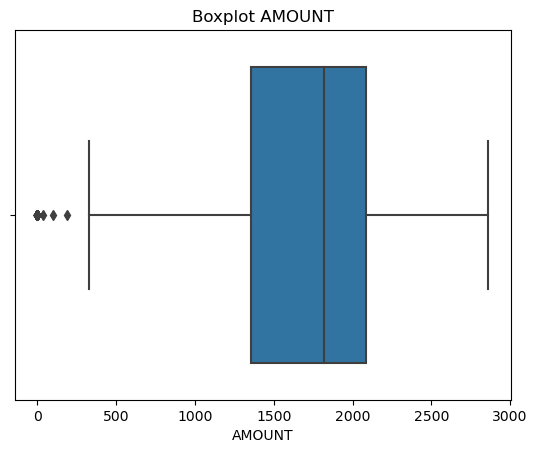

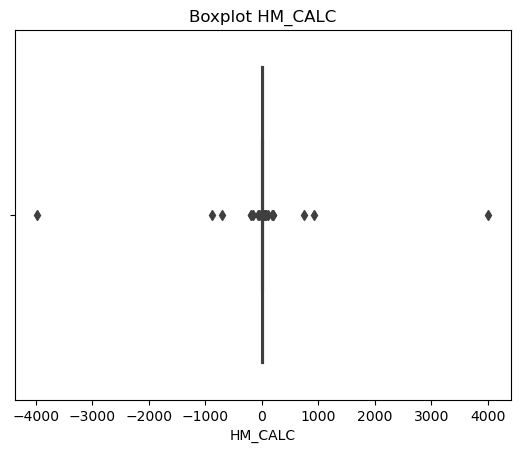

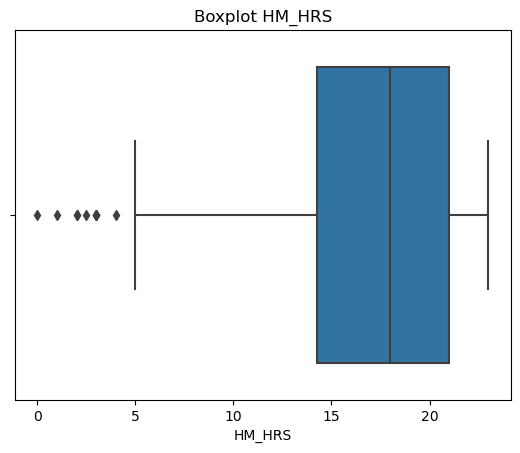

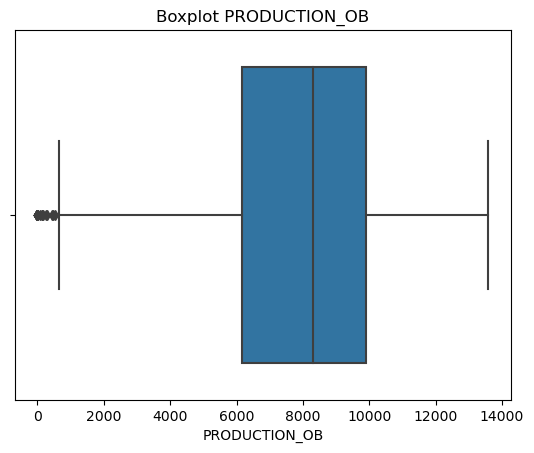

<Figure size 640x480 with 0 Axes>

In [29]:
for i in ['AMOUNT', 'HM_CALC', 'HM_HRS', 'PRODUCTION_OB']:
      sns.boxplot(data = df, x = i)
      plt.title("Boxplot %s" % i)
      plt.show()
      plt.clf()

In [ ]:
sns.boxplot(data= df[['AMOUNT', 'HM_CALC', 'HM_HRS', 'PRODUCTION_OB']])

In [63]:
df = df[(df['HM_CALC']>=0) & (df['HM_CALC']<=24)]

**Note**

Banyak outlier, akan dilakukan filter

## Checking Data Distribution

<Figure size 640x480 with 0 Axes>

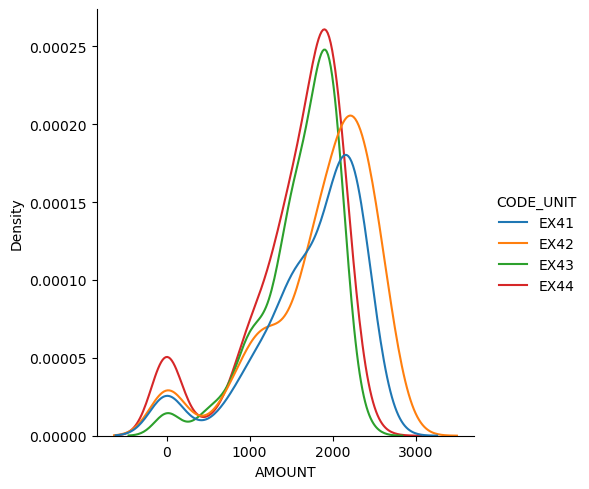

In [64]:
fig = plt.figure()
ax = sns.displot(data = df, kind='kde', x = 'AMOUNT', hue='CODE_UNIT')
plt.show()

<Figure size 640x480 with 0 Axes>

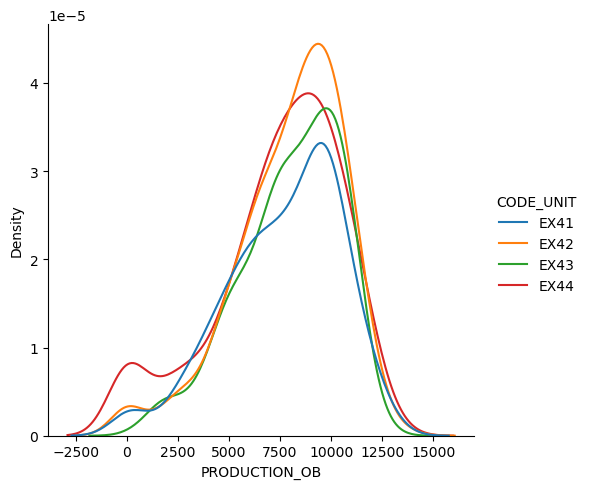

In [65]:
fig = plt.figure()
ax = sns.displot(data = df, kind='kde', x = 'PRODUCTION_OB', hue='CODE_UNIT')
plt.show()

In [68]:
df.groupby('CODE_UNIT')[['AMOUNT', 'PRODUCTION_OB']].mean()

,AMOUNT,PRODUCTION_OB
CODE_UNIT,,
EX41,1729.108696,7689.328986
EX42,1834.710059,8015.301775
EX43,1600.358885,8030.215679
EX44,1533.962644,7461.982759


In [69]:
df.groupby('CODE_UNIT')[['AMOUNT', 'PRODUCTION_OB']].median()

,AMOUNT,PRODUCTION_OB
CODE_UNIT,,
EX41,1922.5,8102.0
EX42,2043.0,8471.0
EX43,1736.0,8370.0
EX44,1717.0,8019.5


In [73]:
# pembuatan feature baru bernama productivity yang menjelaskan hubungan antara production overburden dengan jumlah bahan bakar yang dikonsumsi
df['PRODUCTIVITY'] = df['PRODUCTION_OB']/df['AMOUNT']

In [77]:
df[df['PRODUCTIVITY'].isna()]

,CODE_UNIT,DATE,AMOUNT,HM_CALC,HM_HRS,PRODUCTION_OB,CONSUMPTION_CALC,CONSUMPTION_HRS,PRODUCTIVITY
109,EX41,2022-04-20,0.0,0.0,0.0,0.0,NaN,NaN,NaN
486,EX42,2022-05-02,0.0,7.0,NaN,0.0,0.0,NaN,NaN
1216,EX44,2022-05-02,0.0,7.0,NaN,0.0,0.0,NaN,NaN


In [78]:
df = df[df['PRODUCTIVITY'].notna()]

In [82]:
df.sample(10)

,CODE_UNIT,DATE,AMOUNT,HM_CALC,HM_HRS,PRODUCTION_OB,CONSUMPTION_CALC,CONSUMPTION_HRS,PRODUCTIVITY
984,EX43,2022-09-12,2154.0,11.0,20.0,9718.0,195.818182,107.700000,4.511606
283,EX41,2022-10-11,2175.0,21.0,22.0,9331.0,103.571429,98.863636,4.290115
1207,EX44,2022-04-23,1823.0,21.0,NaN,7611.0,86.809524,NaN,4.174986
1291,EX44,2022-07-16,1041.0,24.0,NaN,1075.0,43.375000,NaN,1.032661
547,EX42,2022-07-02,2435.0,20.0,NaN,3225.0,121.750000,NaN,1.324435
1145,EX44,2022-02-20,1583.0,15.0,NaN,172.0,105.533333,NaN,0.108654
496,EX42,2022-05-12,1058.0,10.0,NaN,4773.0,105.800000,NaN,4.511342
784,EX43,2022-02-24,1591.0,15.0,12.0,5005.0,106.066667,132.583333,3.145820
1120,EX44,2022-01-26,1945.0,23.0,NaN,9331.0,84.565217,NaN,4.797429
980,EX43,2022-09-08,941.0,18.0,20.0,8492.0,52.277778,47.050000,9.024442


In [85]:
filter infinite value
df = df[df['PRODUCTIVITY']!=np.inf]

In [86]:
df.groupby('CODE_UNIT')['PRODUCTIVITY'].mean()

CODE_UNIT
EX41    4.803572
EX42    5.131284
EX43    5.592498
EX44    4.600786
Name: PRODUCTIVITY, dtype: float64

Text(0, 0.5, 'Productivity Score')

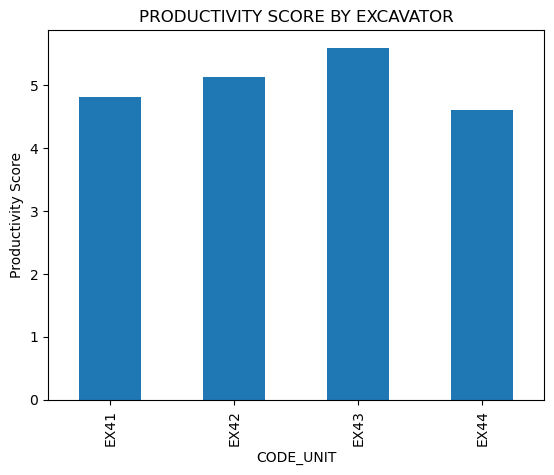

In [88]:
df.groupby('CODE_UNIT')['PRODUCTIVITY'].mean().plot(kind='bar')
plt.title("PRODUCTIVITY SCORE BY EXCAVATOR")
plt.ylabel("Productivity Score")

**Findings**

- Berdasarkan productivity score tidak terlihat perbedaan yang signifikan antara EX41, EX42, EX43, dan EX44 sehingga dengan fakta tersebut kita bisa berasumsi bahwa Excavator2 ini adalah unit yang sama, karena hubungan nilai konsumsi bahan bakar dengan jumlah overburden yang dihasilkan dalam data 1 tahun cenderung tidak berbeda
- Dengan asumsi ini dalam melakukan modeling kita tidak akan memperhitungkan code unit sebagai hal yang berpengaruh terhadap model sehingga code unit selanjutnya akan di drop pada saat modeling

## Correlation checking

Pada correlation checking yang akan dijadikan target adalah amount/konsumsi bahan bakar, sementara feature adalah variabel yang lainnya

In [91]:
df.corr(numeric_only=True)

,AMOUNT,HM_CALC,HM_HRS,PRODUCTION_OB,CONSUMPTION_CALC,CONSUMPTION_HRS,PRODUCTIVITY
AMOUNT,1.000000,0.489813,-0.030187,0.167094,0.163840,0.370047,-0.397134
HM_CALC,0.489813,1.000000,-0.068545,0.174465,-0.468297,0.214939,-0.187784
HM_HRS,-0.030187,-0.068545,1.000000,0.922720,0.051098,-0.677625,0.405282
PRODUCTION_OB,0.167094,0.174465,0.922720,1.000000,-0.033549,-0.622067,0.241443
CONSUMPTION_CALC,0.163840,-0.468297,0.051098,-0.033549,1.000000,0.019882,-0.117631
CONSUMPTION_HRS,0.370047,0.214939,-0.677625,-0.622067,0.019882,1.000000,-0.459948
PRODUCTIVITY,-0.397134,-0.187784,0.405282,0.241443,-0.117631,-0.459948,1.000000


<AxesSubplot: >

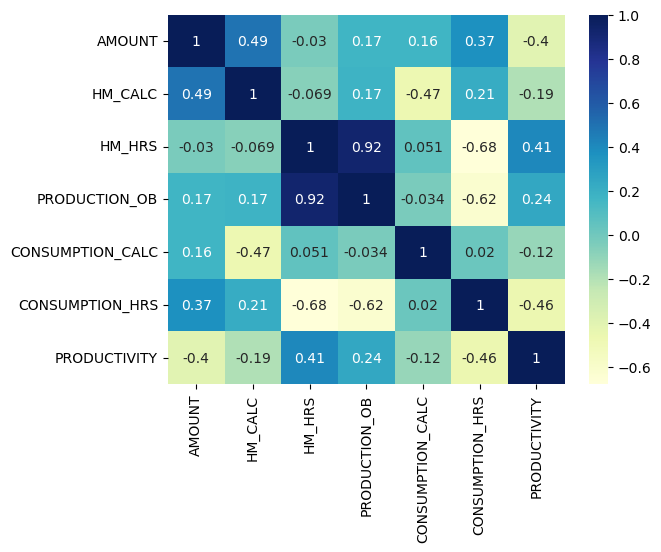

In [92]:
sns.heatmap(df.corr(numeric_only=True), cmap="YlGnBu", annot=True)

**Findings**

- Berdasarkan hasil korelasi antara feature dengan label, kita dapat mengetahui ada beberapa feature yang potensial dengan justifikasi memilii korelasi yang cukup tinggi, misalnya HM_CAL, PRODUCTION_OB, dan PRODUCTIVITY
- Namun karena productivity merupakan hasil bagi Amount dan production sehingga fitur tersebut tidak akan digunakan
- Sementara consumption yang merupakan variabel yang dihasilkan juga dari hasil bagi antara amount/HM juga tidak akan digunakan
- Variabel yang akan digunakan dalam permodelan adalah HM_CAL dan PRODUCTION_OB untuk melihat hubungan antar variabel tersebut terhadap AMOUNT (Konsumsi bahan bakar)

# Modeling

Pada percobaan ini akan dicoba 2 model, yaitu linear regression untuk melihat hubungan antar 3 variabel dan memprediksi kebutuhan bahan bakar berdasarkan target produksi dan target working hours

## Data Preparation

In [98]:
df_modeling = df[['HM_CALC', 'PRODUCTION_OB' , 'AMOUNT']].copy()

In [99]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [102]:
X = df_modeling.drop('AMOUNT', axis=1)
y = df_modeling['AMOUNT']

In [103]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=88)

In [105]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [107]:
X_train_scaled = pd.DataFrame(X_train_scaled, index=X_train.index, columns=X_train.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, index=X_test.index, columns=X_test.columns)

## Model Training

### Linear regression

In [123]:
lin_reg = sm.OLS(y_train, sm.add_constant(X_train_scaled))
lin_reg_model = lin_reg.fit()

In [125]:
print(lin_reg_model.summary())

                            OLS Regression Results                            
Dep. Variable:                 AMOUNT   R-squared:                       0.250
Model:                            OLS   Adj. R-squared:                  0.248
Method:                 Least Squares   F-statistic:                     156.8
Date:                Wed, 15 Feb 2023   Prob (F-statistic):           1.66e-59
Time:                        00:19:13   Log-Likelihood:                -7028.7
No. Observations:                 944   AIC:                         1.406e+04
Df Residuals:                     941   BIC:                         1.408e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const          1770.4163     13.507    131.070

In [136]:
print(lin_reg_model.summary2())

                  Results: Ordinary least squares
Model:               OLS              Adj. R-squared:     0.248     
Dependent Variable:  AMOUNT           AIC:                14063.3852
Date:                2023-02-15 00:46 BIC:                14077.9356
No. Observations:    944              Log-Likelihood:     -7028.7   
Df Model:            2                F-statistic:        156.8     
Df Residuals:        941              Prob (F-statistic): 1.66e-59  
R-squared:           0.250            Scale:              1.7223e+05
--------------------------------------------------------------------
                Coef.   Std.Err.    t     P>|t|    [0.025    0.975] 
--------------------------------------------------------------------
const         1770.4163  13.5074 131.0700 0.0000 1743.9082 1796.9245
HM_CALC        229.7485  13.7389  16.7225 0.0000  202.7861  256.7108
PRODUCTION_OB   36.7777  13.7389   2.6769 0.0076    9.8153   63.7400
-----------------------------------------------------

In [126]:
lin_reg_model.params

const            1770.416314
HM_CALC           229.748465
PRODUCTION_OB      36.777658
dtype: float64

In [128]:
y_pred_lin_reg_test = lin_reg_model.predict(sm.add_constant(X_test_scaled))
y_pred_lin_reg_train = lin_reg_model.predict(sm.add_constant(X_train_scaled))

In [129]:
train_rmse = mean_squared_error(y_train, y_pred_lin_reg_train, squared=False)
test_rmse = mean_squared_error(y_test, y_pred_lin_reg_test, squared=False)
train_mae = mean_absolute_error(y_train, y_pred_lin_reg_train)
test_mae = mean_absolute_error(y_test, y_pred_lin_reg_test)
train_r2 = r2_score(y_train, y_pred_lin_reg_train)
test_r2 = r2_score(y_test, y_pred_lin_reg_test)

print("Linear Regression")
print("Train RMSE:", train_rmse)
print("Test RMSE:", test_rmse)
print("Train MAE:", train_mae)
print("Test MAE:", test_mae)
print("Train R2", train_r2)
print("Test R2", test_r2)

Linear Regression
Train RMSE: 414.34974621299125
Test RMSE: 403.60231032274174
Train MAE: 306.4158666124819
Test MAE: 301.022173376015
Train R2 0.24999069258002682
Test R2 0.23269471965111832


In [130]:
lin_reg_model.params

const            1770.416314
HM_CALC           229.748465
PRODUCTION_OB      36.777658
dtype: float64

**Findings**

- Berdasarkan matrics evaluasi dapat diketahui bahwa model tidak cukup baik untuk melakukan prediksi kebutuhan bahan bakar, sehingga diperlukan tindakan lebih lanjut untuk mengevaluasi data yang tersedia.
- Banyak sekali data point yang tidak sinkron, misalnya terdapat data produksi namun tidak ada data konsumsi bahan bakar, ada beberapa data bahan bakar yang tidak tersedia pada 1 file, namun tersedia pada file lain.
- Data variabel yang tidak tersedia secara lengkap juga bisa jadi menjadi penyebab tidak baiknya model.